In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_NE_305stop.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

5.5981458193603476e-09


In [28]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0,
             A_drift = 0.0)-> np.double:
    
    tau_cbovw = 51430
    omega_cbovw = 0.01197
    
    tau_drift = 8800
    
    
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Ndrift =  (1 + A_drift * exp (-time/tau_drift))
    Ndriftf =  (1 + A_drift * exp (-(time + T_a/2)/tau_drift))
    Ndriftb =  (1 + A_drift * exp (-(time - T_a/2)/tau_drift))

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)

In [29]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.34062e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        #1.38419e+05,
        94208,
        1.39311e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.40369e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        2.97694e+08,
        0.0069,
        18600,
        0.00014,
        4.2,
        0.001]

In [30]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [31]:
p_init=pars2

In [32]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [33]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [34]:
for ipar in range(0,27):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22892894820491672        +-   1.6826867741583914e-05   

-44.477287373991885        +-   0.48902144147305693   

4.014184611265388        +-   7.48238439505922e-05   

0.0022984564509372428        +-   2.4940885464352253e-05   

253726.73829580026        +-   8412.081454124218   

0.0023411582775013343        +-   3.5848674669262215e-07   

-0.5091017652010049        +-   0.05613262904231107   

0.0008373920503485354        +-   7.551418557985195e-05   

-6.818507183964557        +-   0.10421687325745911   

-7.106859164144004e-05        +-   7.539849292099687e-05   

34.17382297572937        +-   1.0827165423656755   

0.00019790352220149586        +-   3.121683956645533e-05   

175161.83412530768        +-   56071.30900518271   

0.013929770638089813        +-   1.830802261450682e-06   

-0.3758563592629235        +-   0.15819511044296714   

0.001428454274164979        +-   0.00021298065665650165   

28147.52756191062        +-   2659.8063064545618   

0.01403729287646298        +

In [35]:
pars_final

array([ 2.28928948e-01, -4.44772874e+01,  4.01418461e+00,  2.29845645e-03,
        2.53726738e+05,  2.34115828e-03, -5.09101765e-01,  8.37392050e-04,
       -6.81850718e+00, -7.10685916e-05,  3.41738230e+01,  1.97903522e-04,
        1.75161834e+05,  1.39297706e-02, -3.75856359e-01,  1.42845427e-03,
        2.81475276e+04,  1.40372929e-02, -2.08596710e+01,  1.23534560e-04,
        9.08982898e+00,  3.03288081e+08,  7.02164255e-03,  1.97223105e+04,
        3.63645412e-03, -3.67429445e+02, -8.33170009e-04])

In [36]:
stdevs

array([1.68268677e-05, 4.89021441e-01, 7.48238440e-05, 2.49408855e-05,
       8.41208145e+03, 3.58486747e-07, 5.61326290e-02, 7.55141856e-05,
       1.04216873e-01, 7.53984929e-05, 1.08271654e+00, 3.12168396e-05,
       5.60713090e+04, 1.83080226e-06, 1.58195110e-01, 2.12980657e-04,
       2.65980631e+03, 3.35747805e-06, 1.49298118e-01, 1.59146146e-05,
       1.69141894e-01, 6.34471073e+07, 2.58755500e-03, 6.52718906e+03,
       2.80005491e-03, 7.71759132e-01, 4.15635458e-03])

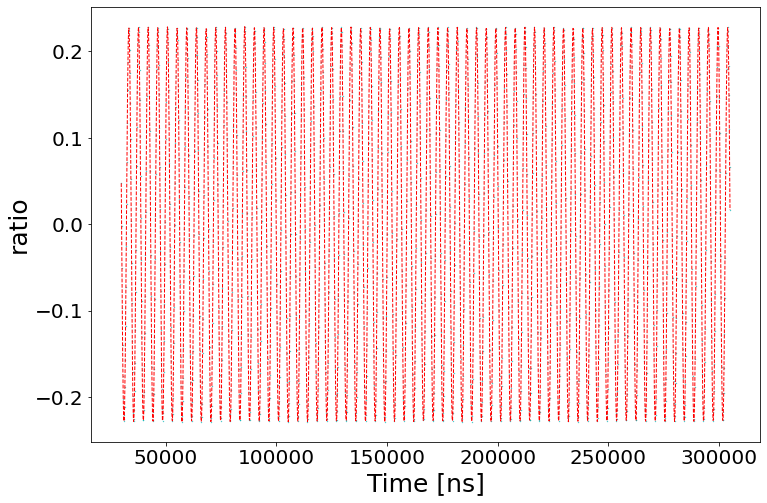

In [37]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [38]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

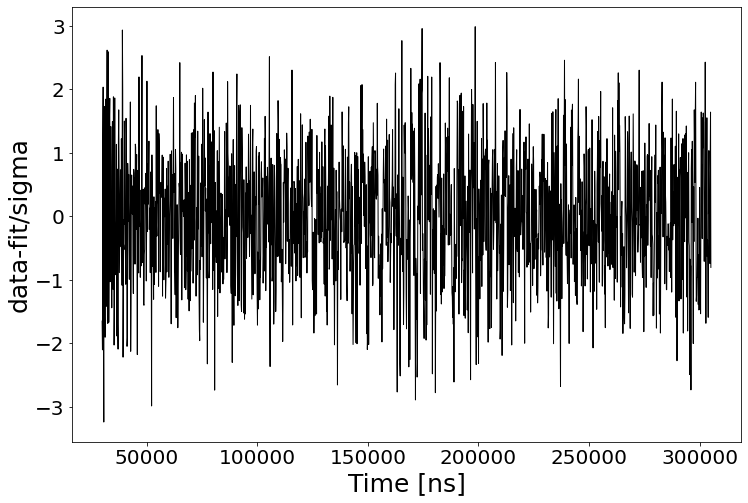

In [39]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [40]:
stdevs

array([1.68268677e-05, 4.89021441e-01, 7.48238440e-05, 2.49408855e-05,
       8.41208145e+03, 3.58486747e-07, 5.61326290e-02, 7.55141856e-05,
       1.04216873e-01, 7.53984929e-05, 1.08271654e+00, 3.12168396e-05,
       5.60713090e+04, 1.83080226e-06, 1.58195110e-01, 2.12980657e-04,
       2.65980631e+03, 3.35747805e-06, 1.49298118e-01, 1.59146146e-05,
       1.69141894e-01, 6.34471073e+07, 2.58755500e-03, 6.52718906e+03,
       2.80005491e-03, 7.71759132e-01, 4.15635458e-03])

In [41]:
fou=abs(np.fft.fft(res))

In [42]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9081788440567067

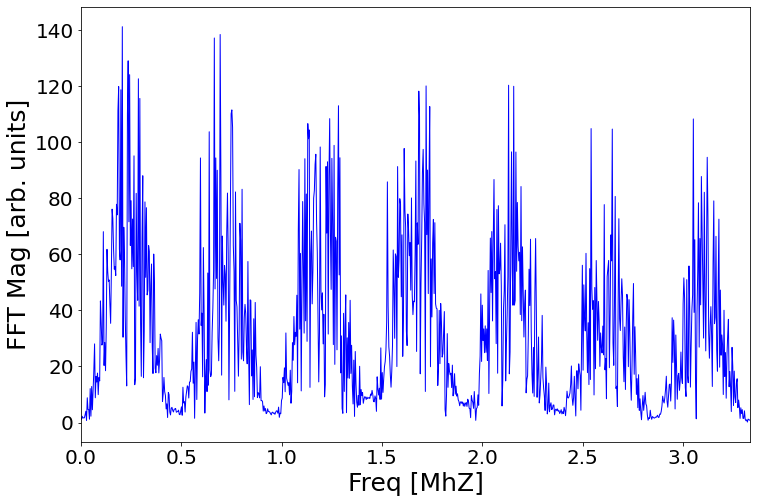

In [43]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [44]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [45]:
chi2

1716.9326239636475

In [46]:
ndf=fit_range-len(pars_final)

In [47]:
red_chi2=chi2/ndf

In [48]:
red_chi2

0.9496308760860882

In [49]:
ndf

1808